In [28]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, BatchNormalization, Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn import metrics

#local module that I created to help with text preprocessing
import text_processing as t_proc

In [3]:
#VIDHYA_DATA = 'training_data/vidhya_data.csv'
NAACL_DATA = 'training_data/NAACL_revised.csv'

#vidhya_data = pd.read_csv(VIDHYA_DATA, usecols=['label', 'tweet'])
naacl_data = pd.read_csv(NAACL_DATA, usecols=['label', 'text'])

training_data = naacl_data #pd.concat([vidhya_data, naacl_data]).reset_index(drop=True)

print(training_data.describe())
training_data.sample(10)

              label
count  11192.000000
mean       0.262598
std        0.440066
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000


,label,text
7003,0,"What if my skin is so white it glows, and I've..."
5529,0,Bad bad food. Plain and simple Kat. #MKR
6686,0,@girlziplocked I WANT TO SEE THIS. but storify...
7746,0,"Oh, look who is ban evading. Well, I guess I'l..."
9118,0,@trentmkays @drurbanski except that features l...
6472,0,"RT @a_man_in_black: @freebsdgirl Hey, did you ..."
10811,0,RT @iknowaboutstuff: Update: ripped this passi...
3689,0,I think Lynn and Tony might be in trouble. If ...
4457,0,#mkr why would anyone want to eat chicken live...
69,1,Nikki...Kermit the frog called and he wants hi...


In [5]:
tweets = list(training_data.text)
labels = np.array(training_data.label)

tweets = [t_proc.glove_preprocess(t) for t in tweets]
tweets_tokenized = [t_proc.tokenize_status_text(t) for t in tweets]

Problem with hashtag #MrBurns???... skipping.


In [6]:
# Create hash for Twitter vocab

MAX_VOCAB_SIZE = 20000

counter = Counter()
for t in tweets_tokenized:
    counter.update(t)

vocab = [x[0] for x in counter.most_common(MAX_VOCAB_SIZE)]

vocab_size = len(vocab)

# Reserve 0 for unknown tokens
hash_dict = dict((vocab[i], i+1) for i in range(vocab_size))

# Save hashmap for later
with open('hashmap.json', 'w', encoding='utf-8') as fh:
    json.dump(hash_dict, fh, ensure_ascii=False)

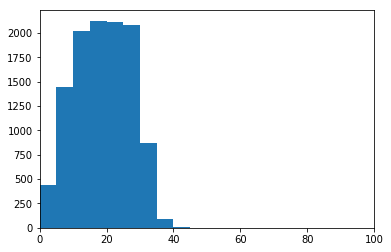

In [7]:
tweet_lens = [len(t) for t in tweets_tokenized]
plt.xlim((0,100))
plt.hist(tweet_lens, bins=range(0,100,5))
plt.show()

In [8]:
# Hash and pad tweets
MAX_INPUT_LEN = 40 # len 40 should be plenty based on previous histogram

def hash_token(t):
    hashcode = hash_dict.get(t)
    if hashcode is not None:
        return hashcode
    else:
        # Hash unknown tokens as 0
        return 0

tweets_hashed = [[hash_token(t) for t in tweet] for tweet in tweets_tokenized]
tweets_padded = pad_sequences(tweets_hashed, maxlen=MAX_INPUT_LEN)

In [80]:
# Create embedding dict from Glove pre-trained embeddings
EMBEDDING_DIM = 25
embedding_file = 'word_embeddings/glove.twitter.27B.{}d.txt'.format(EMBEDDING_DIM)

emb_dict = {}
with open(embedding_file, encoding='utf-8') as fh:
    for line in fh:
        chunks = line.split(' ')
        word = chunks[0]
        vec = np.array(chunks[1:], dtype='float32')
        emb_dict[word] = vec

In [81]:
# Create embedding matrix with hashmap and pre-trained embeddings

embedding_matrix = np.zeros((vocab_size+1, EMBEDDING_DIM), dtype='float32')
for i in range(1, vocab_size+1):
    embedding_vector = emb_dict.get(vocab[i-1])
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    #If the embedding dict doesn't have this token, it will be translated
    # as a vector of zeroes.

# Build embedding layer to plug into Keras Sequential model
embedding = Embedding(input_dim=vocab_size+1,
                      output_dim=EMBEDDING_DIM,
                      weights=[embedding_matrix],
                      input_length=MAX_INPUT_LEN,
                      trainable=False)

In [14]:
# Construct model
SAVE_AS = 'modelv2.h5'

# General model structure & regularizer weights adapted from Pitsilis et al 2018
model = Sequential()
model.add(embedding)
model.add(LSTM(200, activation='elu'))
model.add(BatchNormalization())
model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.9)))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.1)))

'''
callbacks = [EarlyStopping(monitor='val_loss', patience=4),
             ModelCheckpoint(filepath=SAVE_AS, monitor='val_loss', save_best_only=True)]
'''

model.compile(loss='binary_crossentropy', optimizer=Adam(amsgrad=True), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 50)            861500    
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               200800    
_________________________________________________________________
batch_normalization_3 (Batch (None, 200)               800       
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
_________________________________________________________________
batch_normalization_4 (Batch (None, 100)               400       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 1,083,701
Trainable params: 221,601
Non-trainable params: 862,100
______________________________________________________________

In [12]:
#The data is imbalanced, so we need to figure out what class weights to use
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(labels),
                                                  labels)

#Split into training and validation sets
np.random.seed(152)
X_train, X_test, y_train, y_test = train_test_split(tweets_padded, labels,
                                                    test_size=0.2, shuffle=True)

In [15]:
hist = model.fit(X_train, y_train,
                 batch_size=500, epochs=20,
                 validation_data=(X_test, y_test),
                 class_weight=class_weights)

Train on 8953 samples, validate on 2239 samples
Epoch 1/20
8953/8953 [==============================] - 16s 2ms/step - loss: 100.7038 - acc: 0.6879 - val_loss: 81.1466 - val_acc: 0.5547
Epoch 2/20
8953/8953 [==============================] - 13s 1ms/step - loss: 66.4667 - acc: 0.8070 - val_loss: 52.3939 - val_acc: 0.8205
Epoch 3/20
8953/8953 [==============================] - 12s 1ms/step - loss: 42.7619 - acc: 0.8399 - val_loss: 33.3766 - val_acc: 0.8249
Epoch 4/20
8953/8953 [==============================] - 12s 1ms/step - loss: 26.9681 - acc: 0.8480 - val_loss: 20.8286 - val_acc: 0.8227
Epoch 5/20
8953/8953 [==============================] - 12s 1ms/step - loss: 16.7002 - acc: 0.8616 - val_loss: 12.7836 - val_acc: 0.8428
Epoch 6/20
8953/8953 [==============================] - 13s 2ms/step - loss: 10.1666 - acc: 0.8640 - val_loss: 7.7905 - val_acc: 0.8379
Epoch 7/20
8953/8953 [==============================] - 12s 1ms/step - loss: 6.1010 - acc: 0.8683 - val_loss: 4.6722 - val_acc: 0.

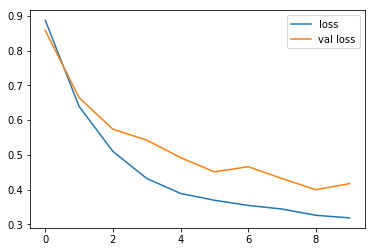

In [16]:
plt.plot(hist.history['loss'][10:], label='loss')
plt.plot(hist.history['val_loss'][10:], label='val loss')
plt.legend()
plt.show()

In [17]:
def prob_to_class(predictions, cutoff=0.5):
    return np.array([1 if p[0] > cutoff else 0 for p in predictions])


predictions = model.predict(X_test)

classes = prob_to_class(predictions)
print(metrics.classification_report(y_test, classes))

tn, fp, fn, tp = metrics.confusion_matrix(y_test, classes).ravel()
print('false positive rate:', fp/(fp+tn))

#Save false positive rate for later
with open('false_positive_rate.txt', 'w') as fh:
      fh.write(str(fp/(fp+tn)))

              precision    recall  f1-score   support

           0       0.83      0.99      0.90      1654
           1       0.94      0.43      0.59       585

   micro avg       0.84      0.84      0.84      2239
   macro avg       0.88      0.71      0.75      2239
weighted avg       0.86      0.84      0.82      2239

false positive rate: 0.010278113663845224


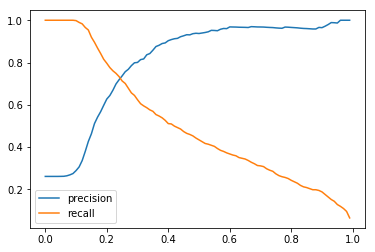

In [18]:
domain = np.linspace(0, 1, 100, endpoint=False)
precisions = [metrics.precision_score(y_test, prob_to_class(predictions, cutoff)) for cutoff in domain]
recalls = [metrics.recall_score(y_test, prob_to_class(predictions, cutoff)) for cutoff in domain]

#Plot precision-recall curve
plt.plot(domain, precisions, label='precision')
plt.plot(domain, recalls, label='recall')
plt.legend()
plt.show()

Let's try rebuilding the model but allowing the embeddings to be trained:

In [45]:
embedding = Embedding(input_dim=vocab_size+1,
                      output_dim=EMBEDDING_DIM,
                      weights=[embedding_matrix],
                      input_length=MAX_INPUT_LEN,
                      trainable=True)
model = Sequential()
model.add(embedding)
model.add(LSTM(200, activation='elu'))
model.add(BatchNormalization())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.1)))

model.compile(loss='binary_crossentropy', optimizer=Adam(amsgrad=True), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 40, 50)            861500    
_________________________________________________________________
lstm_10 (LSTM)               (None, 200)               200800    
_________________________________________________________________
batch_normalization_18 (Batc (None, 200)               800       
_________________________________________________________________
dense_18 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 100)               400       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 101       
Total para

In [46]:
hist = model.fit(X_train, y_train,
                 batch_size=500, epochs=10,
                 validation_data=(X_test, y_test),
                 class_weight=class_weights)

Train on 8953 samples, validate on 2239 samples
Epoch 1/10
8953/8953 [==============================] - 20s 2ms/step - loss: 0.8180 - acc: 0.6716 - val_loss: 0.6840 - val_acc: 0.7753
Epoch 2/10
8953/8953 [==============================] - 18s 2ms/step - loss: 0.6292 - acc: 0.7977 - val_loss: 0.5301 - val_acc: 0.8401
Epoch 3/10
8953/8953 [==============================] - 19s 2ms/step - loss: 0.5188 - acc: 0.8441 - val_loss: 0.4835 - val_acc: 0.8464
Epoch 4/10
8953/8953 [==============================] - 19s 2ms/step - loss: 0.4542 - acc: 0.8650 - val_loss: 0.4631 - val_acc: 0.8553
Epoch 5/10
8953/8953 [==============================] - 19s 2ms/step - loss: 0.4073 - acc: 0.8788 - val_loss: 0.4584 - val_acc: 0.8584
Epoch 6/10
8953/8953 [==============================] - 18s 2ms/step - loss: 0.3681 - acc: 0.8888 - val_loss: 0.3916 - val_acc: 0.8669
Epoch 7/10
8953/8953 [==============================] - 18s 2ms/step - loss: 0.3296 - acc: 0.9053 - val_loss: 0.4535 - val_acc: 0.8584
Epoch 8

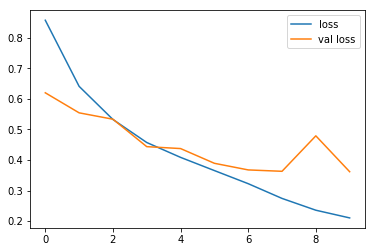

In [35]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [36]:
predictions = model.predict(X_test)

classes = prob_to_class(predictions)
print(metrics.classification_report(y_test, classes))

tn, fp, fn, tp = metrics.confusion_matrix(y_test, classes).ravel()
print('false positive rate:', fp/(fp+tn))

#Save false positive rate for later
with open('false_positive_rate.txt', 'w') as fh:
      fh.write(str(fp/(fp+tn)))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1654
           1       0.81      0.72      0.76       585

   micro avg       0.88      0.88      0.88      2239
   macro avg       0.86      0.83      0.84      2239
weighted avg       0.88      0.88      0.88      2239

false positive rate: 0.06106408706166868


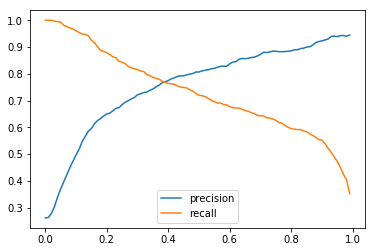

In [37]:
domain = np.linspace(0, 1, 100, endpoint=False)
precisions = [metrics.precision_score(y_test, prob_to_class(predictions, cutoff)) for cutoff in domain]
recalls = [metrics.recall_score(y_test, prob_to_class(predictions, cutoff)) for cutoff in domain]

#Plot precision-recall curve
plt.plot(domain, precisions, label='precision')
plt.plot(domain, recalls, label='recall')
plt.legend()
plt.show()

In [58]:
#Get the updated embedding matrix
emb_weights = embedding.get_weights()[0]
np.save('embedding_weights.npy', emb_weights)

In [76]:
#Try using a similar model architecture like the one in Badjatiya et al
embedding = Embedding(input_dim=vocab_size+1,
                      output_dim=EMBEDDING_DIM,
                      weights=[embedding_matrix],
                      input_length=MAX_INPUT_LEN,
                      trainable=True)
model = Sequential()
model.add(embedding)
model.add(Dropout(0.25))
model.add(LSTM(50, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(amsgrad=True), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 40, 100)           1723000   
_________________________________________________________________
dropout_11 (Dropout)         (None, 40, 100)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_12 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 51        
Total params: 1,753,251
Trainable params: 1,753,251
Non-trainable params: 0
_________________________________________________________________


In [77]:
hist = model.fit(X_train, y_train,
                 batch_size=500, epochs=15,
                 validation_data=(X_test, y_test),
                 class_weight=class_weights)

Train on 8953 samples, validate on 2239 samples
Epoch 1/15
8953/8953 [==============================] - 14s 2ms/step - loss: 0.5936 - acc: 0.7263 - val_loss: 0.5495 - val_acc: 0.7405
Epoch 2/15
8953/8953 [==============================] - 11s 1ms/step - loss: 0.5376 - acc: 0.7566 - val_loss: 0.4814 - val_acc: 0.7834
Epoch 3/15
8953/8953 [==============================] - 11s 1ms/step - loss: 0.4437 - acc: 0.8125 - val_loss: 0.3942 - val_acc: 0.8289
Epoch 4/15
8953/8953 [==============================] - 11s 1ms/step - loss: 0.3860 - acc: 0.8366 - val_loss: 0.3435 - val_acc: 0.8562
Epoch 5/15
8953/8953 [==============================] - 11s 1ms/step - loss: 0.3445 - acc: 0.8602 - val_loss: 0.3221 - val_acc: 0.8638
Epoch 6/15
8953/8953 [==============================] - 11s 1ms/step - loss: 0.3076 - acc: 0.8743 - val_loss: 0.3283 - val_acc: 0.8665
Epoch 7/15
8953/8953 [==============================] - 11s 1ms/step - loss: 0.2813 - acc: 0.8857 - val_loss: 0.2954 - val_acc: 0.8776
Epoch 8

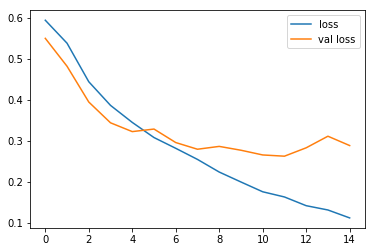

In [78]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [79]:
predictions = model.predict(X_test)

classes = prob_to_class(predictions)
print(metrics.classification_report(y_test, classes))

tn, fp, fn, tp = metrics.confusion_matrix(y_test, classes).ravel()
print('false positive rate:', fp/(fp+tn))

#Save false positive rate for later
with open('false_positive_rate.txt', 'w') as fh:
      fh.write(str(fp/(fp+tn)))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1654
           1       0.79      0.79      0.79       585

   micro avg       0.89      0.89      0.89      2239
   macro avg       0.86      0.86      0.86      2239
weighted avg       0.89      0.89      0.89      2239

false positive rate: 0.07376058041112454


In [99]:
metrics.balanced_accuracy_score(y_test, classes)

0.8571368038115317

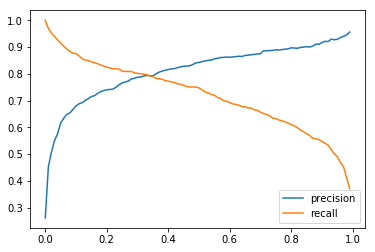

In [71]:
domain = np.linspace(0, 1, 100, endpoint=False)
precisions = [metrics.precision_score(y_test, prob_to_class(predictions, cutoff)) for cutoff in domain]
recalls = [metrics.recall_score(y_test, prob_to_class(predictions, cutoff)) for cutoff in domain]

#Plot precision-recall curve
plt.plot(domain, precisions, label='precision')
plt.plot(domain, recalls, label='recall')
plt.legend()
plt.show()

In [83]:
#Get the updated embedding matrix
emb_weights = embedding.get_weights()[0]
np.save('embedding_weights.npy', emb_weights)